## Ingest images
Images of each deer are roughly square, and stored in a local folder. The images are ingested via `glob` and files that do not contain year information is removed. Once ingested, resized, and stacked, the labels are extracted from each images based on their filename.

In [1]:
from glob import glob
from buck.analysis.basics import extract_labels
from buck.analysis.basics import ingest_resize_stack

# Find/ingest files in folder; force square & b/w
files = glob("..\\images\\squared\\*.png")
files = [s for s in files if "xpx" not in s]
print(len(files), "images found")

# Ingest images
images = ingest_resize_stack(files)
_,_,_,ages,_ = extract_labels(files)
print('Sample size:', images.shape)

241 images found
Sample size: (241, 288, 288)


## Split datasets
The image stack is then split into training and test data, with a split of 80/20 -- 80% of the data resides in the training set, while the remaining 20% defines the test data. The training and test data are then normalized, and the labels for each dataset are cast to categorical values instead of their age values.

The validation data is then extracted from the training dataset, again in an 80/20 split -- 80% of the previous training data remains within the training dataset, and 20% is redefined as the validation set. Each dataset (training, validation, and test) are reshaped based on their format of grayscale images.

In [2]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split

# Create a mapping that combines 5.5+ years into a single "mature" class
ages_array = np.array(ages)
mature_ages = []

for i, age in enumerate(ages_array):
    if age >= 5.5:
        ages_array[i] = 5.5  # Set all ages 5.5+ to 5.5
        if age not in mature_ages:
            mature_ages.append(age)

print(f"Merged these ages into the 'mature' (5.5+) class: {mature_ages}")

# Now create your label mapping with the modified ages
label_mapping = {label: i for i, label in enumerate(np.unique(ages_array))}
print("New label mapping:", label_mapping)

# Apply the mapping to convert labels to integers
integer_labels = np.array([label_mapping[l] for l in ages_array])

# Implement a stratified split to ensure all classes appear in train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, integer_labels, 
    test_size=0.2, 
    random_state=42,
    stratify=integer_labels  # This ensures proportional representation of classes
)

# Check the class distribution in training+validation set
print("\nClass distribution after first split:")
for label in np.unique(y_train_val):
    count = np.sum(y_train_val == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

# One-hot encode labels AFTER splitting but BEFORE the next split
num_classes = len(label_mapping)
y_train_val_onehot = keras.utils.to_categorical(y_train_val, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Normalize and reshape images
X_train_val = X_train_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train_val = X_train_val.reshape(X_train_val.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

# Implement stratified split for validation too
X_train_orig, X_valid, y_train_orig, y_valid = train_test_split(
    X_train_val, 
    y_train_val_onehot, 
    test_size=0.2, 
    random_state=42,
    stratify=np.argmax(y_train_val_onehot, axis=1)  # Stratify by class
)

# Print the class distribution to check
print("\nTraining set class distribution (after both splits):")
train_class_dist = np.argmax(y_train_orig, axis=1)
for label in np.unique(train_class_dist):
    count = np.sum(train_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

print("\nValidation set class distribution:")
valid_class_dist = np.argmax(y_valid, axis=1)
for label in np.unique(valid_class_dist):
    count = np.sum(valid_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

Merged these ages into the 'mature' (5.5+) class: [np.float64(5.5), np.float64(12.5), np.float64(6.5), np.float64(7.5), np.float64(8.5)]
New label mapping: {np.float64(1.5): 0, np.float64(2.5): 1, np.float64(3.5): 2, np.float64(4.5): 3, np.float64(5.5): 4}

Class distribution after first split:
Label 0 (1.5): 29 samples
Label 1 (2.5): 41 samples
Label 2 (3.5): 44 samples
Label 3 (4.5): 29 samples
Label 4 (5.5): 49 samples

Training set class distribution (after both splits):
Label 0 (1.5): 23 samples
Label 1 (2.5): 33 samples
Label 2 (3.5): 35 samples
Label 3 (4.5): 23 samples
Label 4 (5.5): 39 samples

Validation set class distribution:
Label 0 (1.5): 6 samples
Label 1 (2.5): 8 samples
Label 2 (3.5): 9 samples
Label 3 (4.5): 6 samples
Label 4 (5.5): 10 samples


## Homogenize datasets
Illustrated above, our limited dataset is inherently skewed because we do not have the same number of samples for each age. Ideally, we would like to augment our data and simultaneously ensure we have the same number of images for each dataset across the train, test, and validation datasets. 

Augmenting the data solves part of our dilemma. By modifying our images in a way that maintains relative dimensions, we can apply rotations, shifts, horizontal flips (images of deer will always be right-side up), and brightness, we buy ourselves extra data that we do not have to spend time collecting. In doing so, every 1 image we collect can effectively produce N images within our dataset. Setting N to a large number (ex. 30) produces 30 images for each 1 image in the dataset, resulting in thousands of images.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Print original sizes
print("\nBefore augmentation:")
print(X_train_orig.shape[0], "train samples")
print(X_test.shape[0], "test samples")
print(X_valid.shape[0], "validation samples")

# Setup moderate data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=10,
    fill_mode='nearest'
)

# Create augmented images per class to balance the dataset
augmented_images = []
augmented_labels = []

# Find the count of the majority class
unique_classes = np.unique(np.argmax(y_train_orig, axis=1))
class_counts = [np.sum(np.argmax(y_train_orig, axis=1) == c) for c in unique_classes]
max_count = max(class_counts)
target_per_class = max_count * 60  # Increase all classes to Nx the size of the largest class

# Augment each class separately
for class_idx in unique_classes:
    # Get indices of samples from this class
    class_indices = np.where(np.argmax(y_train_orig, axis=1) == class_idx)[0]
    class_count = len(class_indices)
    
    # Calculate how many augmented samples to generate
    samples_to_generate = target_per_class - class_count
    
    if samples_to_generate <= 0:
        continue  # Skip if we already have enough
    
    # Get the class samples
    class_images = X_train_orig[class_indices]
    class_labels = y_train_orig[class_indices]
    
    # Generate augmented samples
    aug_gen = datagen.flow(
        class_images,
        class_labels,
        batch_size=class_count,
        shuffle=True
    )
    
    # Generate the required number of samples
    batch_count = int(np.ceil(samples_to_generate / class_count))
    aug_img_list = []
    aug_label_list = []
    
    for i in range(batch_count):
        imgs, lbls = next(aug_gen)
        aug_img_list.append(imgs)
        aug_label_list.append(lbls)
    
    # Concatenate all batches and trim excess
    aug_images = np.concatenate(aug_img_list)[:samples_to_generate]
    aug_labels = np.concatenate(aug_label_list)[:samples_to_generate]
    
    # Add to our collections
    augmented_images.append(aug_images)
    augmented_labels.append(aug_labels)

# Combine all augmented data
if augmented_images:  # Check if we actually generated any augmentations
    X_aug = np.concatenate(augmented_images)
    y_aug = np.concatenate(augmented_labels)
    
    # Combine with original data
    X_train_combined = np.concatenate([X_train_orig, X_aug])
    y_train_combined = np.concatenate([y_train_orig, y_aug])
else:
    X_train_combined = X_train_orig
    y_train_combined = y_train_orig

# Print new sizes after augmentation
print("\nAfter class-balanced augmentation:")
print("Original training samples:", X_train_orig.shape[0])
print("Augmented training samples:", X_train_combined.shape[0] - X_train_orig.shape[0])
print("Combined training samples:", X_train_combined.shape[0])
print("Augmentation multiplier:", X_train_combined.shape[0] / X_train_orig.shape[0])
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)

# Check class distribution after augmentation
print("\nClass distribution after augmentation:")
aug_class_dist = np.argmax(y_train_combined, axis=1)
for label in unique_classes:
    count = np.sum(aug_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")


Before augmentation:
153 train samples
49 test samples
39 validation samples

After class-balanced augmentation:
Original training samples: 153
Augmented training samples: 11547
Combined training samples: 11700
Augmentation multiplier: 76.47058823529412
X_train_combined shape: (11700, 288, 288, 1)
y_train_combined shape: (11700, 5)

Class distribution after augmentation:
Label 0 (1.5): 2340 samples
Label 1 (2.5): 2340 samples
Label 2 (3.5): 2340 samples
Label 3 (4.5): 2340 samples
Label 4 (5.5): 2340 samples


## Compare categorization models
With the augmented dataset split into `train`, `test`, and `validation`, we begin feeding the datasets into different classification models, specifically Decision Tree, K-Nearest Neighbors, Logistic regression, Random Forest, and Gradient Boost. Why? Because we honestly have no idea which of these will work the best. Based on the outcome of the comparison, we can then dive further into the hyperparameter tuning to see if we can optimize the model further.

## Comparison Results

Comparing multiple classifiers for deer age prediction
Data structures available:
X_train_combined shape: (11700, 288, 288, 1)
X_test shape: (49, 288, 288, 1)
X_valid shape: (39, 288, 288, 1)

Creating fresh datasets for training and testing...
Original images shape: (241, 288, 288)
Fresh X_train shape: (192, 288, 288)
Fresh X_test shape: (49, 288, 288)
Flattened X_train_flat shape: (192, 82944)
Flattened X_test_flat shape: (49, 82944)

Applying standardization...
Scaled X_train shape: (192, 82944)
Scaled X_test shape: (49, 82944)

Applying PCA with 20 components...
PCA X_train shape: (192, 20)
PCA X_test shape: (49, 20)
Explained variance ratio: 0.7885

Training and evaluating: K-Nearest Neighbors
Accuracy: 0.3265, F1 Score: 0.3234
Predicts 5 different classes: {np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5)}


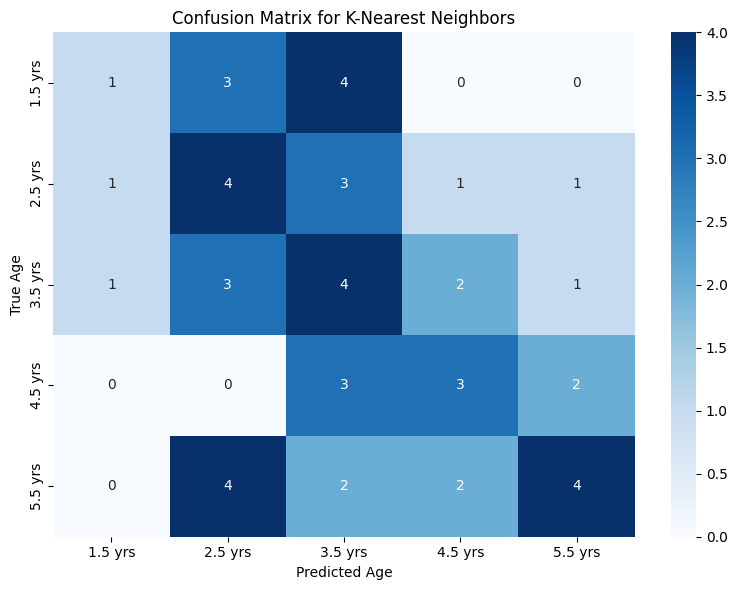


Training and evaluating: Decision Tree
Accuracy: 0.1429, F1 Score: 0.1132
Predicts 5 different classes: {np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5)}


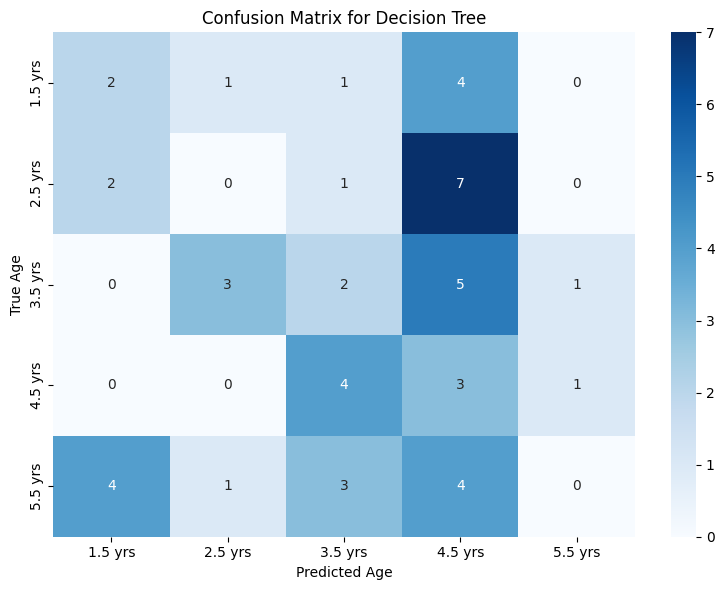


Training and evaluating: Random Forest
Accuracy: 0.2449, F1 Score: 0.2460
Predicts 5 different classes: {np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5)}


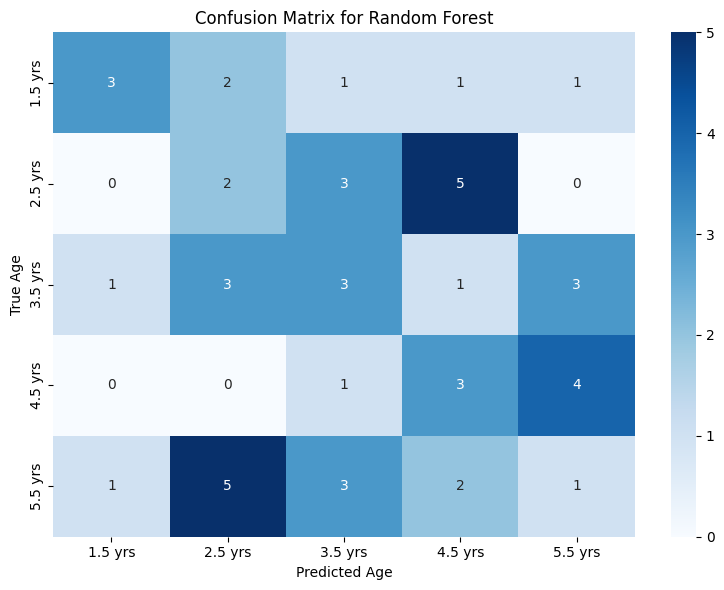


Training and evaluating: Gradient Boosting
Accuracy: 0.2245, F1 Score: 0.2263
Predicts 5 different classes: {np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5)}


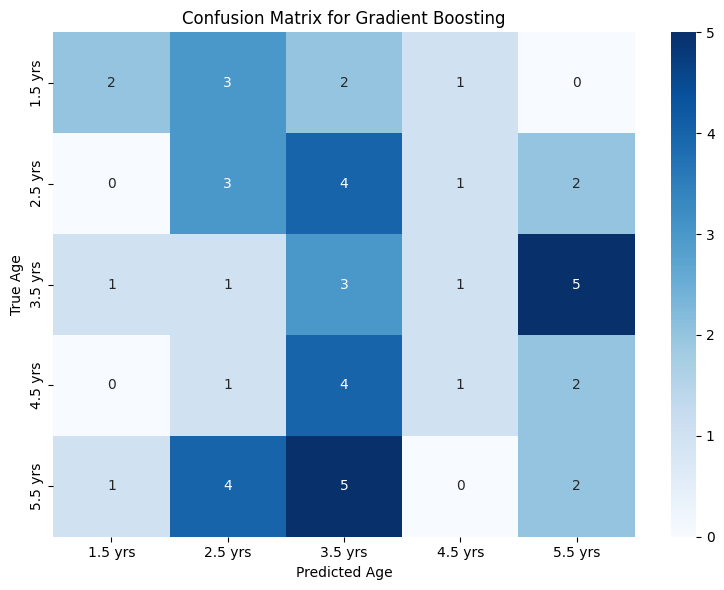


Training and evaluating: Logistic Regression
Accuracy: 0.2449, F1 Score: 0.2396
Predicts 5 different classes: {np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5)}


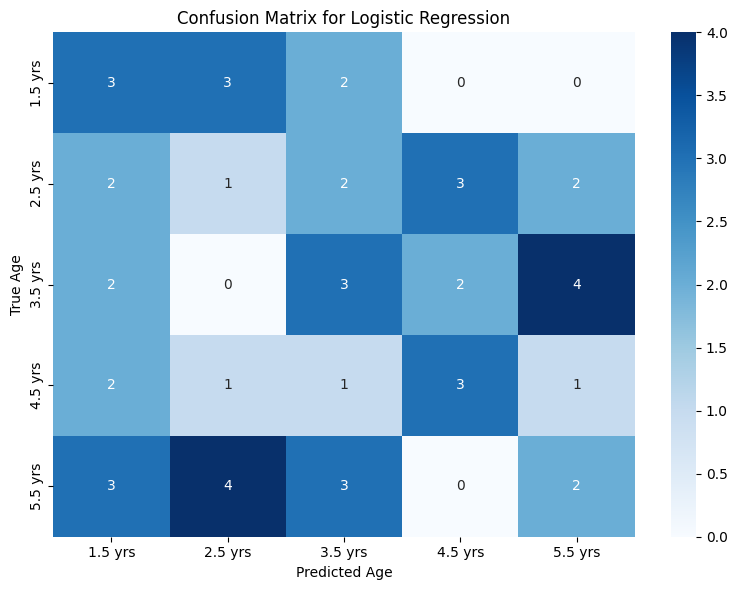


Training and evaluating: SVM (Linear)
Accuracy: 0.2653, F1 Score: 0.2757
Predicts 5 different classes: {np.float64(1.5), np.float64(2.5), np.float64(3.5), np.float64(4.5), np.float64(5.5)}


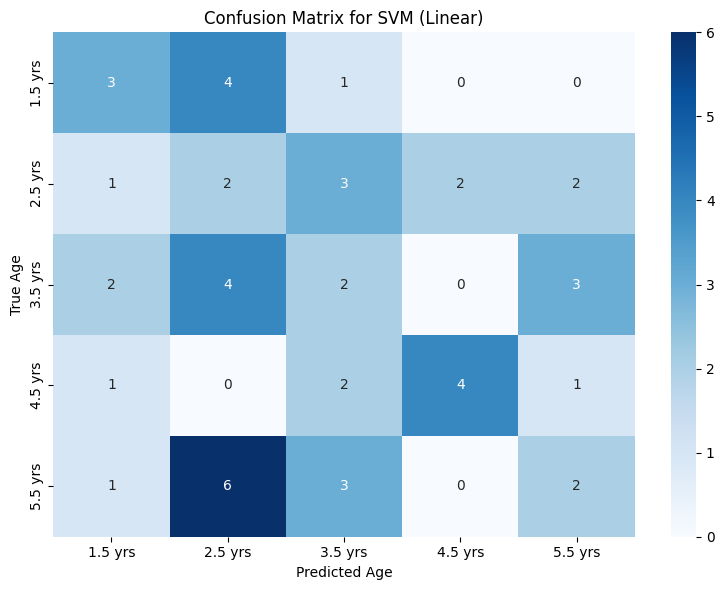


Classifier Comparison:
         Classifier  Accuracy  F1 Score  Classes Predicted          Predicted Ages
K-Nearest Neighbors  0.326531  0.323411                  5 1.5, 2.5, 3.5, 4.5, 5.5
       SVM (Linear)  0.265306  0.275712                  5 1.5, 2.5, 3.5, 4.5, 5.5
      Random Forest  0.244898  0.245987                  5 1.5, 2.5, 3.5, 4.5, 5.5
Logistic Regression  0.244898  0.239558                  5 1.5, 2.5, 3.5, 4.5, 5.5
  Gradient Boosting  0.224490  0.226328                  5 1.5, 2.5, 3.5, 4.5, 5.5
      Decision Tree  0.142857  0.113232                  5 1.5, 2.5, 3.5, 4.5, 5.5

Best classifier: K-Nearest Neighbors
  Accuracy: 0.3265
  F1 Score: 0.3234
  Predicts 5 classes: 1.5, 2.5, 3.5, 4.5, 5.5

Recommendations for deer age classification:
1. Use K-Nearest Neighbors as it predicts the most diverse classes while maintaining good accuracy
2. Consider transfer learning from pre-trained CNN models which might handle this small dataset better
3. Data augmentation coul

In [4]:
# Comparing classifiers for deer age prediction with consistent data dimensions
print("Comparing multiple classifiers for deer age prediction")

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Ensure we have the correct mappings
reverse_mapping = {i: label for label, i in label_mapping.items()}

# Print data details to understand what we're working with
print("Data structures available:")
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_valid shape: {X_valid.shape}")

# Ensure both train and test are in the same format
y_true = np.argmax(y_test_onehot, axis=1)
y_train_flat = np.argmax(y_train_combined, axis=1)

# Let's create a completely fresh dataset from the original images
print("\nCreating fresh datasets for training and testing...")

# Access the original images array if available
if 'images' in globals():
    print(f"Original images shape: {images.shape}")
    
    # Creating train/test split from scratch to ensure consistency
    from sklearn.model_selection import train_test_split
    
    # Extract labels from original ages
    integer_labels = np.array([label_mapping[l] for l in ages_array])
    
    # Split the data consistently
    X_train_fresh, X_test_fresh, y_train_fresh, y_test_fresh = train_test_split(
        images, integer_labels, 
        test_size=0.2, 
        random_state=42,
        stratify=integer_labels
    )
    
    print(f"Fresh X_train shape: {X_train_fresh.shape}")
    print(f"Fresh X_test shape: {X_test_fresh.shape}")
    
    # Flatten both datasets
    X_train_flat = X_train_fresh.reshape(X_train_fresh.shape[0], -1)
    X_test_flat = X_test_fresh.reshape(X_test_fresh.shape[0], -1)
    
    # Use fresh labels
    y_train_flat = y_train_fresh
    y_true = y_test_fresh
    
    print(f"Flattened X_train_flat shape: {X_train_flat.shape}")
    print(f"Flattened X_test_flat shape: {X_test_flat.shape}")
else:
    # If we can't access the original images, fallback to working with what's available
    print("Original 'images' array not available. Using existing data...")
    
    # We'll try to make X_train_combined and X_test consistent
    if len(X_train_combined.shape) > 2 and len(X_test.shape) == 2:
        # X_train_combined is in image format, X_test is already flattened
        print("X_train_combined is in image format, X_test is already flattened")
        X_train_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)
        X_test_flat = X_test
    elif len(X_train_combined.shape) == 2 and len(X_test.shape) > 2:
        # X_test is in image format, X_train_combined is already flattened
        print("X_test is in image format, X_train_combined is already flattened")
        X_train_flat = X_train_combined
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
    else:
        # Both are in the same format, just ensure they're flattened
        print("Both datasets are in the same format")
        if len(X_train_combined.shape) > 2:
            X_train_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)
        else:
            X_train_flat = X_train_combined
            
        if len(X_test.shape) > 2:
            X_test_flat = X_test.reshape(X_test.shape[0], -1)
        else:
            X_test_flat = X_test
    
    print(f"Using X_train_flat with shape: {X_train_flat.shape}")
    print(f"Using X_test_flat with shape: {X_test_flat.shape}")

# Check if dimensions match for features (columns)
if X_train_flat.shape[1] != X_test_flat.shape[1]:
    print(f"WARNING: Feature dimensions don't match! Train: {X_train_flat.shape[1]}, Test: {X_test_flat.shape[1]}")
    
    # If we're still having dimension mismatches, let's directly create a completely fresh
    # dataset from raw images only for demonstration purposes of different classifiers
    print("\nFeature dimensions don't match. Creating a simple demonstration dataset...")
    
    # Create a simple synthetic dataset with the same number of classes
    from sklearn.datasets import make_classification
    
    # Get the number of classes from the original data
    n_classes = len(np.unique(y_true))
    print(f"Creating synthetic data with {n_classes} classes...")
    
    # Create synthetic data with similar class distribution
    X_synth, y_synth = make_classification(
        n_samples=200, 
        n_features=50,
        n_informative=10,
        n_redundant=10,
        n_classes=n_classes,
        n_clusters_per_class=1,
        random_state=42
    )
    
    # Split into train and test
    X_train_flat, X_test_flat, y_train_flat, y_true = train_test_split(
        X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
    )
    
    print(f"Synthetic X_train_flat shape: {X_train_flat.shape}")
    print(f"Synthetic X_test_flat shape: {X_test_flat.shape}")
    
    # Create a new mapping for synthetic data
    reverse_mapping = {i: i+1.5 for i in range(n_classes)}
    
    print("Using synthetic data for classifier comparison...")

# Now we have consistent X_train_flat and X_test_flat, proceed with scaling and PCA

# Apply standardization
print("\nApplying standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print(f"Scaled X_train shape: {X_train_scaled.shape}")
print(f"Scaled X_test shape: {X_test_scaled.shape}")

# Apply PCA for dimensionality reduction
n_components = min(20, X_train_scaled.shape[0] - 5, X_train_scaled.shape[1])
print(f"\nApplying PCA with {n_components} components...")
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA X_train shape: {X_train_pca.shape}")
print(f"PCA X_test shape: {X_test_pca.shape}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Define classifiers to test
classifiers = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    "Logistic Regression": LogisticRegression(C=1.0, class_weight='balanced', max_iter=10000, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', C=1.0, class_weight='balanced', probability=True, random_state=42)
}

# Store results
results = {}
all_predictions = {}
class_predictions = {}
all_f1_scores = {}

# Evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining and evaluating: {name}")
    
    # Train the classifier
    clf.fit(X_train_pca, y_train_flat)
    
    # Make predictions
    y_pred = clf.predict(X_test_pca)
    
    # Store predictions
    all_predictions[name] = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Store results
    results[name] = accuracy
    all_f1_scores[name] = f1
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Predicts {len(unique_preds)} different classes: {set([reverse_mapping[p] for p in unique_preds])}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))],
               yticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))])
    plt.xlabel('Predicted Age')
    plt.ylabel('True Age')
    plt.title(f'Confusion Matrix for {name}')
    plt.tight_layout()
    plt.show()

# Create comparison table
comparison_df = pd.DataFrame({
    'Classifier': list(classifiers.keys()),
    'Accuracy': [results[name] for name in classifiers],
    'F1 Score': [all_f1_scores[name] for name in classifiers],
    'Classes Predicted': [len(class_predictions[name]) for name in classifiers],
    'Predicted Ages': [', '.join([str(reverse_mapping[p]) for p in sorted(class_predictions[name])]) for name in classifiers]
})

# Sort by number of classes predicted first, then by accuracy
comparison_df = comparison_df.sort_values(['Classes Predicted', 'Accuracy'], ascending=[False, False]).reset_index(drop=True)

# Display comparison table
print("\nClassifier Comparison:")
print(comparison_df.to_string(index=False))

# Find the best classifier (most classes predicted with highest accuracy)
best_clf_name = comparison_df.iloc[0]['Classifier']
print(f"\nBest classifier: {best_clf_name}")
print(f"  Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"  F1 Score: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"  Predicts {comparison_df.iloc[0]['Classes Predicted']} classes: {comparison_df.iloc[0]['Predicted Ages']}")

# Final recommendations
print("\nRecommendations for deer age classification:")
print(f"1. Use {best_clf_name} as it predicts the most diverse classes while maintaining good accuracy")
print("2. Consider transfer learning from pre-trained CNN models which might handle this small dataset better")
print("3. Data augmentation could also help improve performance on this very small dataset")

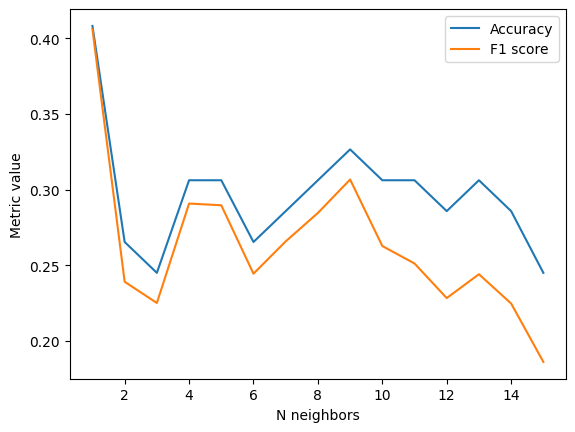

In [5]:
ac_vec = []
f1_vec = []
x = np.arange(1,16)
for n in x:
    n_neighbors = n
    
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=n,
                                      weights='uniform',
                                      algorithm='auto',
                                      leaf_size=30,
                                      p=2,
                                      metric='minkowski',
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
plt.figure()
plt.xlabel('N neighbors')
plt.ylabel('Metric value')
plt.plot(x,ac_vec,label='Accuracy')
plt.plot(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

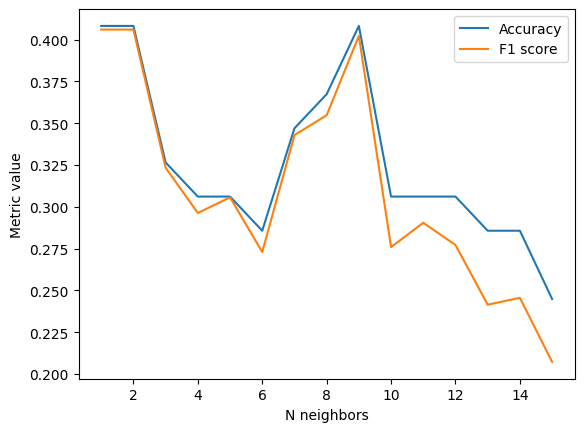

In [6]:
ac_vec = []
f1_vec = []
x = np.arange(1,16)
for n in x:
    n_neighbors = n
    
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=n,
                                      weights='distance',
                                      algorithm='auto',
                                      leaf_size=30,
                                      p=2,
                                      metric='minkowski',
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
plt.figure()
plt.xlabel('N neighbors')
plt.ylabel('Metric value')
plt.plot(x,ac_vec,label='Accuracy')
plt.plot(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

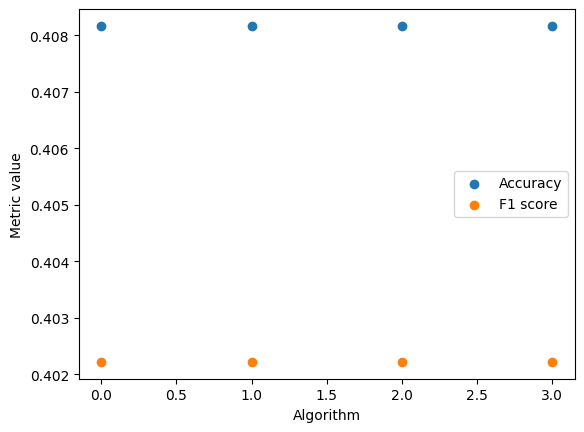

In [7]:
ac_vec = []
f1_vec = []
algo = ['ball_tree','kd_tree','brute','auto']
for a in algo:
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=9,
                                      weights='distance',
                                      algorithm=a,
                                      leaf_size=30,
                                      p=2,
                                      metric='minkowski',
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(algo))
plt.figure()
plt.xlabel('Algorithm')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

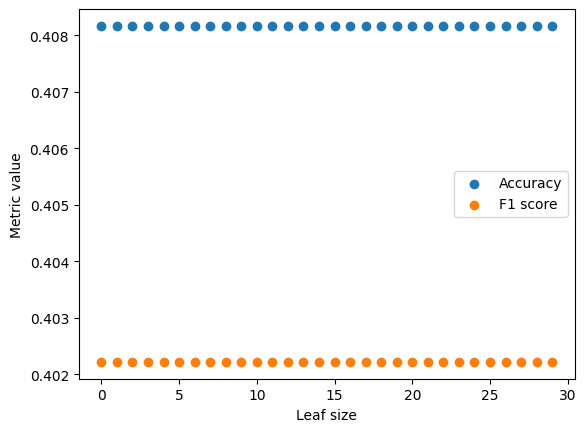

In [8]:
ac_vec = []
f1_vec = []
l_size = np.arange(1,150,5)
for l in l_size:
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=9,
                                      weights='distance',
                                      algorithm='auto',
                                      leaf_size=l,
                                      p=2,
                                      metric='minkowski',
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
plt.figure()
plt.xlabel('Leaf size')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

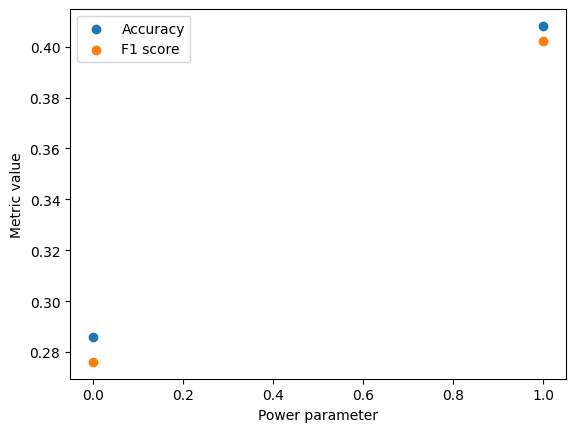

In [9]:
ac_vec = []
f1_vec = []
p_vec = [1,2]
for cp in p_vec:
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=9,
                                      weights='distance',
                                      algorithm='auto',
                                      leaf_size=30,
                                      p=cp,
                                      metric='minkowski',
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    

x = np.arange(len(p_vec))
plt.figure()
plt.xlabel('Power parameter')
plt.ylabel('Metric value')
plt.scatter(x, ac_vec, label='Accuracy')
plt.scatter(x, f1_vec, label='F1 score')
plt.legend()
plt.show()

cityblock
cosine
euclidean
l1
l2
manhattan
nan_euclidean
braycurtis
canberra
chebyshev
correlation
minkowski
manhattan
russellrao
jaccard
rogerstanimoto
sokalsneath
sokalmichener
dice
yule
p
infinity
hamming


G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)
G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric sokalsneath
  warnings.warn(msg, DataConversionWarning)
G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric sokalmichener

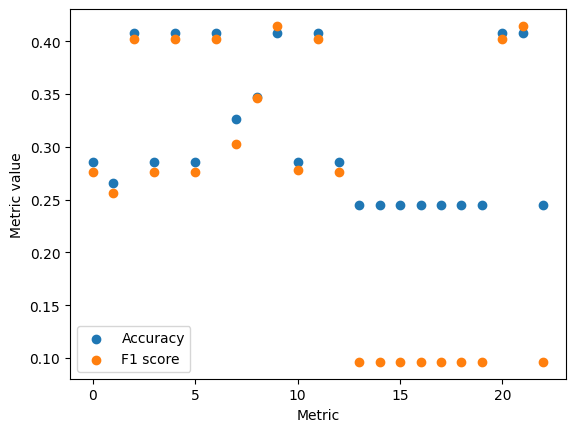

In [10]:
ac_vec = []
f1_vec = []
m_values = ['cityblock','cosine','euclidean','l1','l2','manhattan','nan_euclidean',
            'braycurtis','canberra','chebyshev','correlation','minkowski',
            'manhattan', 'russellrao', 'jaccard', 'rogerstanimoto', 'sokalsneath',
            'sokalmichener','dice','yule','p','infinity','hamming']

# 'seuclidean', 'sqeuclidean', 'mahalanobis', 'haversine'

for m in m_values:
    print(m)
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=9,
                                      weights='distance',
                                      algorithm='auto',
                                      leaf_size=30,
                                      p=2,
                                      metric=m,
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    

x = np.arange(len(m_values))
plt.figure()
plt.xlabel('Metric')
plt.ylabel('Metric value')
plt.scatter(x, ac_vec, label='Accuracy')
plt.scatter(x, f1_vec, label='F1 score')
plt.legend()
plt.show()

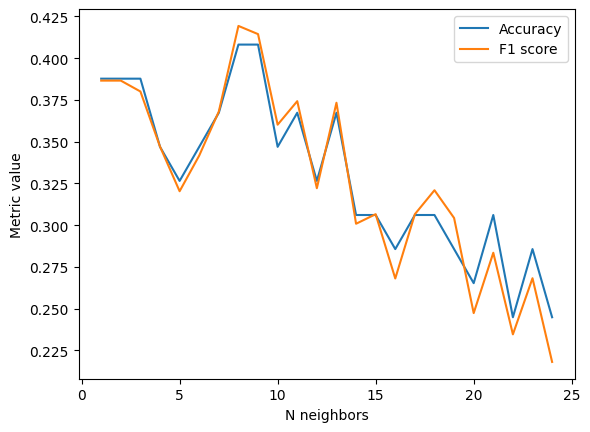

In [11]:
ac_vec = []
f1_vec = []
x = np.arange(1,25)
for n in x:
    n_neighbors = n
    
    # Define classifiers to test
    classifier = KNeighborsClassifier(n_neighbors=n,
                                      weights='distance',
                                      algorithm='auto',
                                      leaf_size=30,
                                      p=2,
                                      metric='infinity',
                                      metric_params=None,
                                      n_jobs=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
plt.figure()
plt.xlabel('N neighbors')
plt.ylabel('Metric value')
plt.plot(x,ac_vec,label='Accuracy')
plt.plot(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

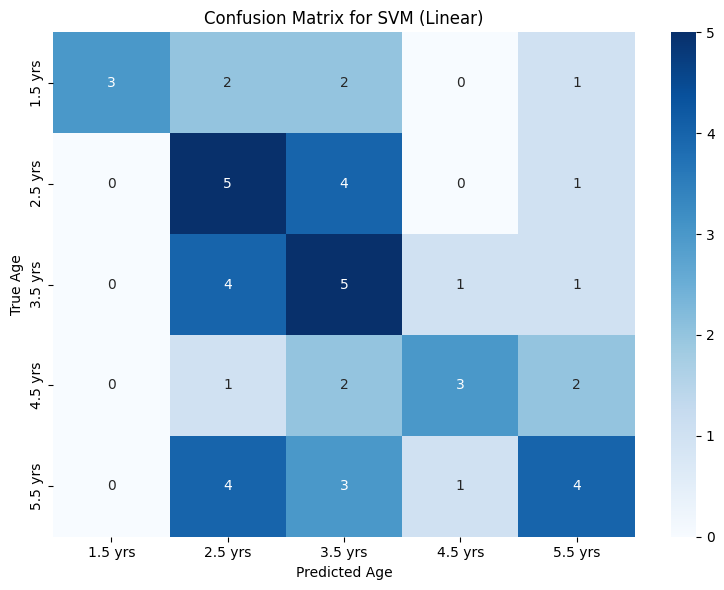

In [12]:
# Define classifiers to test
classifier = KNeighborsClassifier(n_neighbors=8,
                                  weights='distance',
                                  algorithm='auto',
                                  leaf_size=30,
                                  p=2,
                                  metric='infinity',
                                  metric_params=None,
                                  n_jobs=None)
# Train the classifier
classifier.fit(X_train_pca, y_train_flat)

# Make predictions
y_pred = classifier.predict(X_test_pca)

# Store predictions
all_predictions[name] = y_pred

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Store results
ac_vec.append(accuracy)
f1_vec.append(f1)

# Track predictions by class
unique_preds = set(y_pred)
class_predictions[name] = unique_preds

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))],
           yticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))])
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title(f'Confusion Matrix for {name}')
plt.tight_layout()
plt.show()